# Light Field Pipeline

Verify each module works correctly.


## Imports

In [1]:
# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Project modules
from src.lightfield_io import load_hci_lightfield
from src.lightfield_shearing import refocus_shear_single, refocus_shear
from src.central_subap import extract_central_sub_aperture
from src.tensor_extraction import (
    extract_horizontal_epi, extract_vertical_epi,
    extract_all_horizontal_epis, extract_all_vertical_epis,
    compute_horizontal_kld_tensor, compute_vertical_kld_tensor,
    argmax_depth_from_tensor
)
from src.confidence_analysis import compute_confidences
from src.depth_propagation import propagate_depth, fuse_depth_maps, smooth_depth_map

## Constants

In [2]:
# Scene path
SCENE_PATH = "data/additional/town"

# Shear parameter range
MIN_ALPHA = 0.1
MAX_ALPHA = 2.0
N_ALPHAS = 101
ALPHAS = np.linspace(MIN_ALPHA, MAX_ALPHA, num=N_ALPHAS)

# Angular indices for checks
U_CENTER = 4
V_CENTER = 4

# Spatial row/column for EPI extraction
Y_ROW = 128  # example row
X_COL = 128  # example column


## Helper Functions

In [15]:
def show_image(img, title=None, cmap=None):
    """
    Display a single image (H x W x C or H x W)
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def show_depth(depth, title=None, cmap='gray_r'):
    plt.figure(figsize=(6,6))
    plt.imshow(depth, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.colorbar(shrink=0.7)
    plt.show()

## 1. Input LF

Light field shape: (512, 512, 9, 9, 3)
Value range: 0.003921569 - 1.0


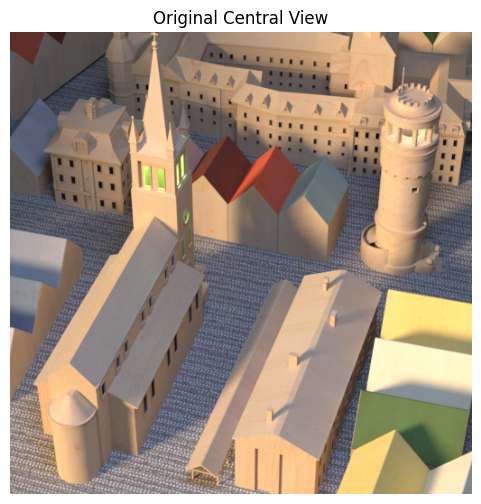

In [4]:
# Load light field
lf = load_hci_lightfield(SCENE_PATH)
print("Light field shape:", lf.shape)
print("Value range:", lf.min(), "-", lf.max())

# Visual check: central view
show_image(lf[:, :, U_CENTER, V_CENTER, :], title="Original Central View")

## 1.1 Central Sub-Aperture Image Extraction

Central Sub-aperture shape (Expected H, W, C): (512, 512, 3)


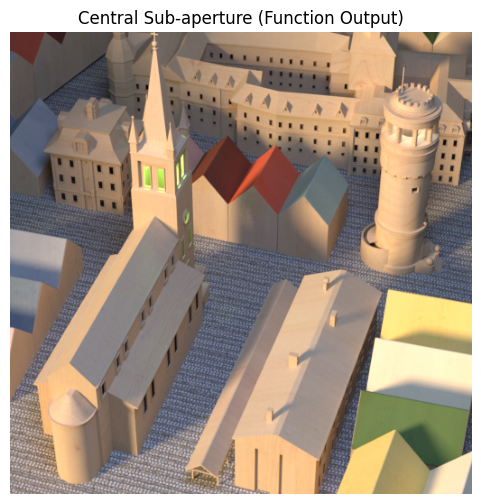

In [5]:
# Extract the central view
central_view = extract_central_sub_aperture(lf)

# Verify the shape: (H, W, C)
print("Central Sub-aperture shape (Expected H, W, C):", central_view.shape)

H, W, U, V, C = lf.shape
assert central_view.shape == (H, W, C), "Central view shape is incorrect."
assert np.allclose(central_view, lf[:, :, U_CENTER, V_CENTER, :]), "Central view does not match direct indexing."

# Visual check: central view from function
show_image(central_view, title="Central Sub-aperture (Function Output)")

## 2. Light Field Shearing

Sheared LF shape: (512, 512, 9, 9, 3)


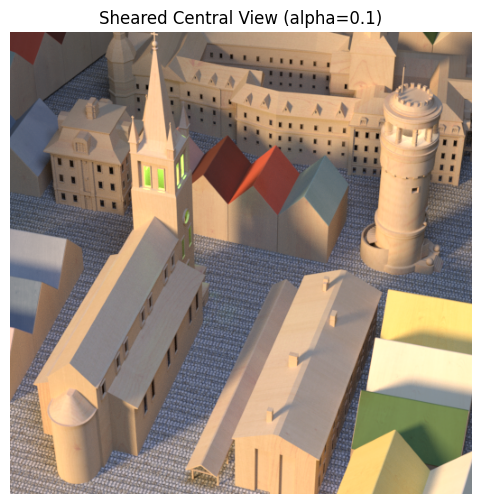

In [6]:
# Apply angular shear
sheared_lf = refocus_shear_single(lf, MIN_ALPHA)
print("Sheared LF shape:", sheared_lf.shape)
assert sheared_lf.shape == lf.shape, "Sheared LF must maintain the original (H, W, U, V, C) shape."

# Visual check: central view after shearing
show_image(sheared_lf[:, :, U_CENTER, V_CENTER, :], 
           title=f"Sheared Central View (alpha={MIN_ALPHA})")

## 3. Tensor Extraction

### 3.1 Single EPI Extraction

Horizontal EPI shape: (512, 9, 3)
Vertical EPI shape: (512, 9, 3)


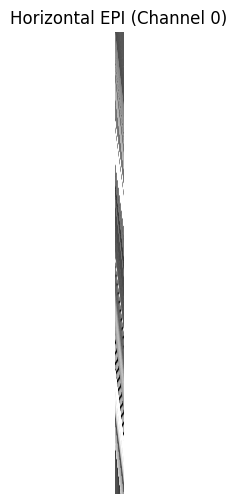

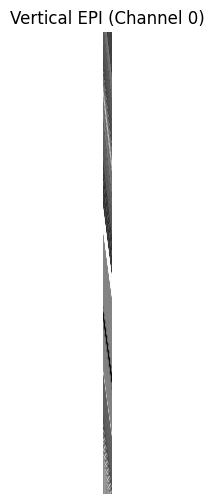

In [7]:
# Extract single horizontal and vertical EPIs at chosen row/column
h_epi = extract_horizontal_epi(sheared_lf, Y_ROW, V_CENTER)
v_epi = extract_vertical_epi(sheared_lf, X_COL, U_CENTER)

print("Horizontal EPI shape:", h_epi.shape)  # (W, U, C)
print("Vertical EPI shape:", v_epi.shape)    # (H, V, C)
assert h_epi.shape == (W, U, C), f"Horizontal EPI shape expected ({W}, {U}, {C}), got {h_epi.shape}."
assert v_epi.shape == (H, V, C), f"Vertical EPI shape expected ({H}, {V}, {C}), got {v_epi.shape}."

# Visual check: horizontal EPI (first channel)
show_image(h_epi[:, :, 0], cmap="gray", title="Horizontal EPI (Channel 0)")

# Visual check: vertical EPI (first channel)
show_image(v_epi[:, :, 0], cmap="gray", title="Vertical EPI (Channel 0)")

### 3.2 Full EPI Stack Extraction

Number of horizontal EPIs: 512
Number of vertical EPIs: 512


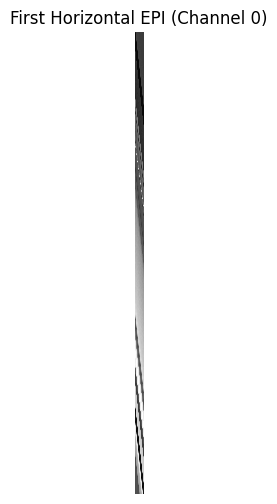

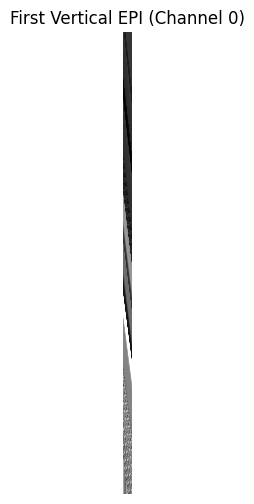

In [8]:
all_h_epis = extract_all_horizontal_epis(sheared_lf, V_CENTER)
all_v_epis = extract_all_vertical_epis(sheared_lf, U_CENTER)

print("Number of horizontal EPIs:", len(all_h_epis))  # Should match H
print("Number of vertical EPIs:", len(all_v_epis))    # Should match W

assert len(all_h_epis) == H, f"Expected {H} horizontal EPIs, got {len(all_h_epis)}."
assert all_h_epis[0].shape == (W, U, C), f"Horizontal EPIs in stack must be shape ({W}, {U}, {C})."
assert len(all_v_epis) == W, f"Expected {W} vertical EPIs, got {len(all_v_epis)}."
assert all_v_epis[0].shape == (H, V, C), f"Vertical EPIs in stack must be shape ({H}, {V}, {C})."

# Visual check: display first horizontal and vertical EPIs
show_image(all_h_epis[0][:, :, 0], cmap="gray", title="First Horizontal EPI (Channel 0)")
show_image(all_v_epis[0][:, :, 0], cmap="gray", title="First Vertical EPI (Channel 0)")

## 4. Refocused Stack Over Many Alphas (Depth Labels)

In [9]:
# Compute full sheared stack (A, H, W, U, V, C)
sheared_stack, (u0, v0) = refocus_shear(lf, ALPHAS, clip_coords=True)
print("sheared_stack shape:", sheared_stack.shape)
print("angular center (u0,v0):", (u0, v0))

sheared_stack shape: (101, 512, 512, 9, 9, 3)
angular center (u0,v0): (4, 4)


## 5. Compute KLD Tensors

In [10]:
# Compute horizontal and vertical KLD tensors
Dh = compute_horizontal_kld_tensor(sheared_stack, v_center=v0, window_radius=2, nbins=16)
Dv = compute_vertical_kld_tensor(sheared_stack, u_center=u0, window_radius=2, nbins=16)

print("Dh shape:", Dh.shape)  # (H, W, A)
print("Dv shape:", Dv.shape)

Dh shape: (512, 512, 101)
Dv shape: (512, 512, 101)


## 6. Convert Tensors to Raw Depth Maps

In [11]:
# Raw depth maps (alpha value per pixel) from horizontal and vertical tensors
depth_h = argmax_depth_from_tensor(Dh, ALPHAS)  # shape (H, W)
depth_v = argmax_depth_from_tensor(Dv, ALPHAS)  # shape (H, W)

print("depth_h shape:", depth_h.shape, "depth_v shape:", depth_v.shape)


depth_h shape: (512, 512) depth_v shape: (512, 512)


## 7. Compute Confidences for Horizontal and Vertical Tensors

In [12]:
conf_h, conf_v = compute_confidences(Dh, Dv, delta=2)
print("conf_h min/max:", conf_h.min(), conf_h.max())
print("conf_v min/max:", conf_v.min(), conf_v.max())

conf_h min/max: 0.0 71.31276
conf_v min/max: 0.0 70.54799


## 8. Fuse and Propagate to Final Depth Map

In [13]:
# Simple Fusion and Smoothing
depth_fused = fuse_depth_maps(depth_h, depth_v, conf_h, conf_v)
depth_final = propagate_depth(depth_h, depth_v, conf_h, conf_v, smooth_sigma=1.0)

print("depth_fused shape:", depth_fused.shape)
print("depth_final shape:", depth_final.shape)

depth_fused shape: (512, 512)
depth_final shape: (512, 512)


## 9. Visualize Results

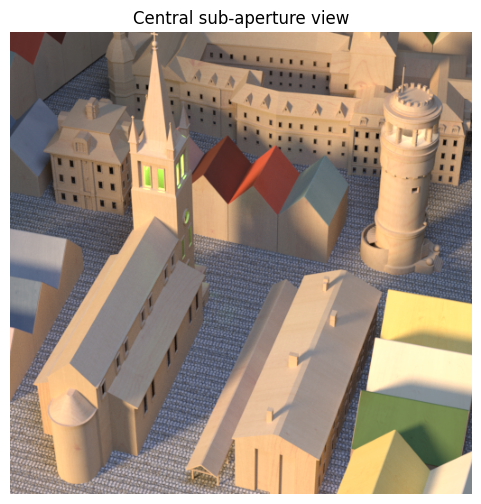

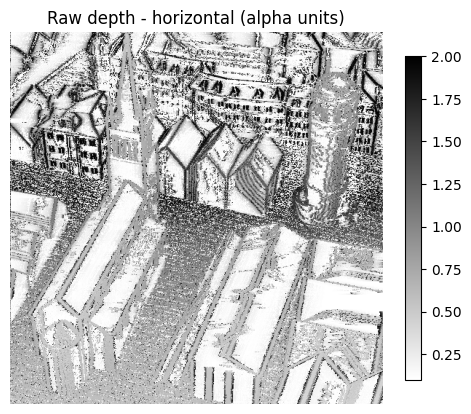

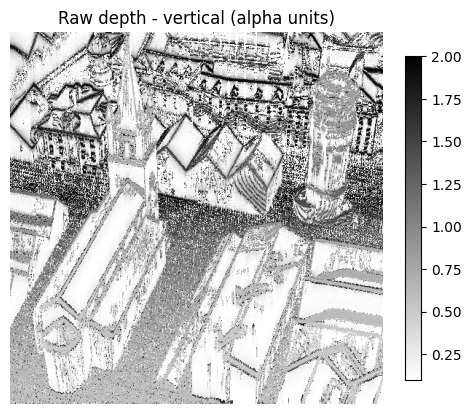

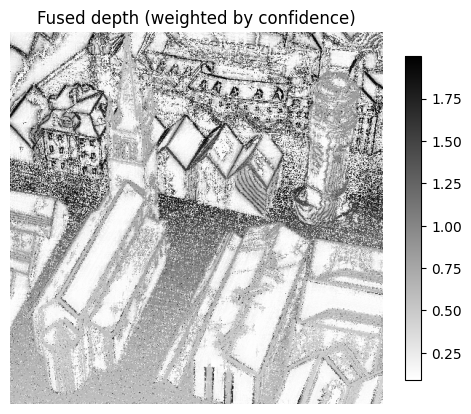

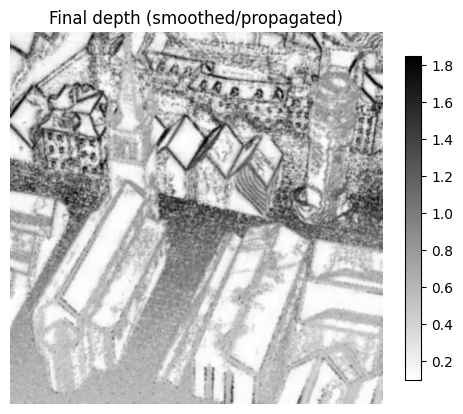

In [16]:
# central RGB view
show_image(central_view, title="Central sub-aperture view")

# raw depth maps
show_depth(depth_h, title="Raw depth - horizontal (alpha units)")
show_depth(depth_v, title="Raw depth - vertical (alpha units)")

# fused and final
show_depth(depth_fused, title="Fused depth (weighted by confidence)")
show_depth(depth_final, title="Final depth (smoothed/propagated)")